## Building Model to Predict Game Outcomes

Now that I have created and extracted the features that I think will be useful for predicting game outcomes, I will go ahead and start building out my models. I will be testing the following models as they perform well for binary classification tasks:

* Ridge Classifier: a linear classification model that performs L2 regularization control multi-collinearity of the features
* K-Neighbors Classifier: predicts categorical outcome by based on k-closest neighbors in the training set, can detect non-linear decision boundaries
* Gradient Boosting Classifier: ensemble model that combines multiple weak learners, normally decision trees, to create a strong learned for classification problems
* Bagging Classifier: boostrap aggregation method that uses one algorithm on different subsets of the training set
* Random Forest Classifier: an ensemble learning model that combines multiple decision trees to create a more accurate model, randomly selects a subset of features for each tree to prevent overfitting and improve accuracy
* Decision Tree Classifier: tree-like model that splits data based on the feature that maximizes information gain or reduces impurity at each node
* Logistic Regression: a statistical model that is commonly used to predict binary outcomes, assumes a linear relationship between the input variables and the log-odds of the outcome
* XGB Classifier: a form of gradient boosting that is useful for controling overfitting in the training set

Before building my model to predict game outcomes, I will self-merge the dataframe so that all rows contain both home team and away team data. Then, I will select the features that can go in to the model (all numeric and boolean features), before using feature selection to further filter out the features with little predictive power. Finally, I will test out different binary classification machine learning models to see which performs best. 

In [334]:
# Putting opponent features into columns
league_games_opp = league_games.copy()
league_games_opp.columns = [f"{col}_opp" if col not in ["GAME_ID", "TEAM_ID"] else col for col in league_games.columns]

# Merge the two dataframes on the 'GAME_ID' column and opposite team IDs
merged_df = pd.merge(league_games, league_games_opp, on=['GAME_ID'], suffixes=['', '_opp'], how='outer')
merged_df = merged_df[merged_df['TEAM_ID'] != merged_df['TEAM_ID_opp']]  

# Cleaning up columns a bit
merged_df = merged_df.drop(columns=['index', 'Unnamed: 0', 'WL', 'index_opp', 'Unnamed: 0_opp', 'SEASON_ID_opp', 'GAME_DATE_opp', 'MATCHUP_opp', 'WL_opp'])

# Inspecting merged dataset
display(merged_df.columns.values)
display(len(merged_df))
display(merged_df.isna().sum())

array(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME',
       'GAME_ID', 'GAME_DATE', 'MATCHUP', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'win_lose_margin', 'home', 'win', 'home_team_abv',
       'away_team_abv', 'matchup_id', 'three_matchup_win_pct',
       'rest_days', 'win_streak', 'MIN_MA', 'PTS_MA', 'FGM_MA', 'FGA_MA',
       'FG_PCT_MA', 'FG3M_MA', 'FG3A_MA', 'FG3_PCT_MA', 'FTM_MA',
       'FTA_MA', 'FT_PCT_MA', 'OREB_MA', 'DREB_MA', 'REB_MA', 'AST_MA',
       'STL_MA', 'BLK_MA', 'TOV_MA', 'PF_MA', 'PLUS_MINUS_MA',
       'win_lose_margin_MA', 'win_MA', 'home_MA', 'rest_days_MA',
       'win_record', 'loss_record', 'season_win_pct', 'elo',
       'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'MIN_opp',
       'PTS_opp', 'FGM_opp', 'FGA_opp', 'FG_PCT_opp', 'FG3M_opp',
       'FG3A_opp', 'FG3_PCT_opp', 'FTM_opp', 'FTA_opp',

21020

SEASON_ID                0
TEAM_ID                  0
TEAM_ABBREVIATION        0
TEAM_NAME                0
GAME_ID                  0
                      ... 
rest_days_MA_opp      2700
win_record_opp           0
loss_record_opp          0
season_win_pct_opp       0
elo_opp                  0
Length: 124, dtype: int64

There are still some missing values from the features I created. Namely, 10-game moving averages will not have any data for the first 10 games played by the team every season, which means the model will only be able to predict outcomes starting from the 11th game. This is fine because teams change season-to-season and it makes sense that the model will have a "warm-up period" to learn the teams before starting to predict. It also takes a while in 2014 for the dataset to accumulate three matchups between all team combinations for the three-matchup win percentage column, so there are missing values there as well. I will proceed to drop rows with missing values, which is about 5,002 rows, or about 23% of my dataset. While this is a high percentage of observations to drop, note that the data is still learning from these instances through moving averages and backward looking statistics such as three-matchup win percentage; it is just not able to predict on them. 

In [335]:
merged_df = merged_df.dropna()
display(len(merged_df))

16018

In [336]:
# Importing additional modules necessary for building and testing models
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Preprocessing and scaling data
merged_df = merged_df.sort_values(by='GAME_DATE')
display(merged_df.head())
removed_columns = ['index', 'home_team_abv_opp', 'away_team_abv_opp', 'home_team_abv', 'away_team_abv',
       'matchup_id_opp', 'matchup_id', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME',
       'GAME_ID', 'GAME_DATE', 'MATCHUP', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'win', 'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp', 
       'TEAM_NAME_opp', 'MIN_opp','PTS_opp', 'FGM_opp', 'FGA_opp', 'FG_PCT_opp', 
       'FG3M_opp', 'FG3A_opp', 'FG3_PCT_opp', 'FTM_opp', 'FTA_opp', 'FT_PCT_opp',
       'OREB_opp', 'DREB_opp', 'REB_opp', 'AST_opp', 'STL_opp', 'BLK_opp',
       'TOV_opp', 'PF_opp', 'PLUS_MINUS_opp', 'home_opp', 'win_opp', 'win_lose_margin', 'win_lose_margin_opp']
selected_columns = merged_df.columns[~merged_df.columns.isin(removed_columns)]


# Scaling all features so they are between 0 and 1
scaler = MinMaxScaler()
merged_df[selected_columns] = scaler.fit_transform(merged_df[selected_columns])

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,MIN,PTS,FGM,...,PF_MA_opp,PLUS_MINUS_MA_opp,win_lose_margin_MA_opp,win_MA_opp,home_MA_opp,rest_days_MA_opp,win_record_opp,loss_record_opp,season_win_pct_opp,elo_opp
2349,22014,1610612738,BOS,Boston Celtics,21400591,2015-01-16,BOS vs. CHI,240,103,42,...,17.4,-3.4,-3.4,0.5,0.8,1.8,26.0,14.0,0.65,1529.743645
2350,22014,1610612741,CHI,Chicago Bulls,21400591,2015-01-16,CHI @ BOS,240,119,48,...,23.0,-3.8,-3.8,0.3,0.5,1.9,13.0,24.0,0.351351,1444.619516
2365,22014,1610612744,GSW,Golden State Warriors,21400593,2015-01-16,GSW @ OKC,239,115,42,...,23.2,-2.1,-2.1,0.5,0.5,2.5,18.0,20.0,0.473684,1524.330657
2366,22014,1610612760,OKC,Oklahoma City Thunder,21400593,2015-01-16,OKC vs. GSW,240,127,51,...,20.0,13.5,13.5,0.8,0.7,2.3,31.0,5.0,0.861111,1663.998881
2469,22014,1610612747,LAL,Los Angeles Lakers,21400622,2015-01-19,LAL @ PHX,240,100,34,...,22.8,3.4,3.4,0.6,0.4,1.9,24.0,18.0,0.571429,1565.558031


Below, I will be performing dimensionality reduction with PCA. Currently, the dataset has 63 features, many of which are correlated with one another (for example, 'FG_PCT' is just a function of 'FGA' and 'FGM'). PCA will help identify the most important features that explain the majority of the variance in the data, as well as help me choose the number of principal components to keep.

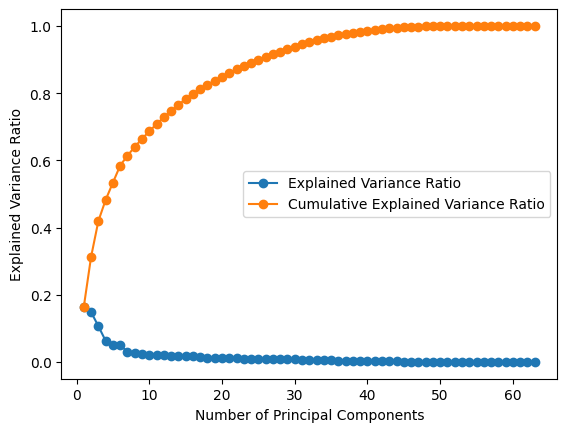

In [337]:
# Dimensionality reduction with PCA
pca = PCA(n_components=63)
X_pca_all_features = pca.fit_transform(merged_df[selected_columns])
fig, ax = plt.subplots()
ax.plot(range(1, 64), pca.explained_variance_ratio_, marker='o', label='Explained Variance Ratio')
ax.plot(range(1, 64), pca.explained_variance_ratio_.cumsum(), marker='o', label='Cumulative Explained Variance Ratio')
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Explained Variance Ratio')
ax.legend()
plt.show()

pca = PCA(n_components=30)
X_pca = pca.fit_transform(merged_df[selected_columns])
y = np.array(merged_df['win']).reshape(-1, 1)
seasons = np.array(merged_df['SEASON_ID']).reshape(-1, 1)
X = np.concatenate([X_pca, y, seasons], axis=1)

According to the graph above, it is evident that the explained variance plateaus after about 40 principal components, so I have reduced my data down to 40 features.

Below, I will define a function called backtest that will allow me to test each of my models on a current season by looking back at all of the previous seasons that are available in the dataset. The function starts predicting after the second season, meaning that it does not predict on the 2014-2015 and 2015-2016 seasons. 

In [338]:
# Backtest
def backtest(X, y, model, start=2, step=1):

    """
    A function to perform backtesting on NBA game data using the input X and output y.
    
    Parameters:
        X (numpy.ndarray): An array of input data of shape (n_samples, n_features).
        y (numpy.ndarray): An array of output data of shape (n_samples,).
        model (object): An object of any scikit-learn compatible model.
        start (int): An integer representing the starting index of the testing seasons in X[:, -1].
        step (int): An integer representing the step size for incrementing the testing seasons.
    
    Returns:
        A pandas DataFrame containing the actual and predicted output values for each testing season.
    """

    # Initialize an empty list to hold all the predictions for each testing season
    all_predictions = []
    
    # Get all the unique seasons in the input data
    seasons = np.unique(X[:, -1])
    
    # Flatten the output data into a 1D array
    y = y.ravel()
    
    # Loop through all the testing seasons to train and test model, return pandas dataframe with actual and predicted outputs
    for i in range(start, len(seasons), step):
        season = seasons[i]
        train_mask = X[:, -1] < season
        test_mask = X[:, -1] == season
        train_X, train_y = X[train_mask, :-2], y[train_mask]
        test_X, test_y = X[test_mask, :-2], y[test_mask]
        model.fit(train_X, train_y)
        preds = model.predict(test_X)
        preds = pd.Series(preds, index=np.where(test_mask)[0])
        combined = pd.concat([pd.Series(test_y.flatten(), index=np.where(test_mask)[0]), preds], axis=1)
        combined.columns = ["actual", "prediction"]
        all_predictions.append(combined)
    return pd.concat(all_predictions)

I will proceed to test my models in two ways. One is through the use of the backtest function, which will predict whether a team won or lost for all games starting in the 2017-2018 season. The model predicts by season, using all previous seasons available in the dataset.

The other way I will test my models is through cross-validation using TimeSeriesSplit, which uses a similar methodology but is season-agnostic. In other words, it splits the data up into 5 consecutive folds and tests the 4 most recent folds on any data that occurs before it, but it may contain a mix of seasons in each fold. 

Ridge Regression Mean Cross-Validation Accuracy Score: 0.6480329711502437
KNN Mean Cross-Validation Accuracy Score: 0.5893593106032222
Support Vector Classifier Mean Cross-Validation Accuracy Score: 0.6352191832146872
Gradient Boosting Mean Cross-Validation Accuracy Score: 0.6431622330460847
Bagging Classifier Mean Cross-Validation Accuracy Score: 0.5990258523791683
Random Forest Classifier Mean Cross-Validation Accuracy Score: 0.6369426751592357
Decision Tree Classifer Mean Cross-Validation Accuracy Score: 0.5637317347321094
Logistic Regression Mean Cross-Validation Accuracy Score: 0.6478081678531286
XGB Classifier Mean Cross-Validation Accuracy Score: 0.6134132633945297


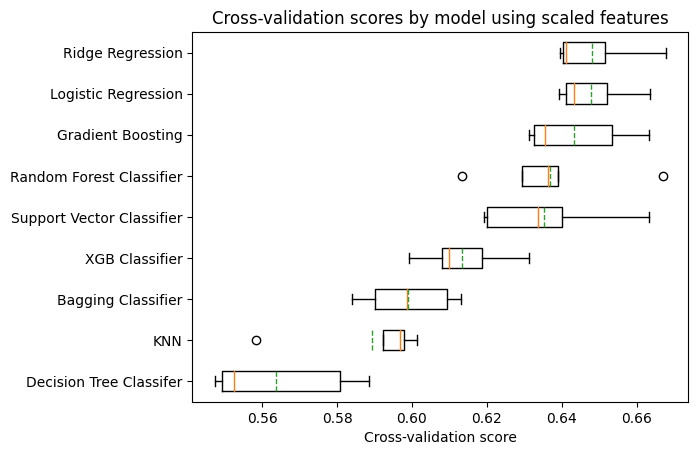

Ridge Regression Test Set Accuracy: 0.6440373563218391
KNN Test Set Accuracy: 0.5900862068965518
Support Vector Classifier Test Set Accuracy: 0.6324712643678161
Gradient Boosting Test Set Accuracy: 0.6405172413793103
Bagging Classifier Test Set Accuracy: 0.6031609195402299
Random Forest Classifier Test Set Accuracy: 0.6385775862068965
Decision Tree Classifer Test Set Accuracy: 0.554382183908046
Logistic Regression Test Set Accuracy: 0.6444683908045977
XGB Classifier Test Set Accuracy: 0.6148706896551724


In [339]:
# Define a dictionary of models to be tested
np.random.seed(41)
models ={"Ridge Regression": RidgeClassifier(random_state=41), "KNN": KNeighborsClassifier(), 
         "Support Vector Classifier": SVC(random_state=41), "Gradient Boosting": GradientBoostingClassifier(random_state=41),
	     "Bagging Classifier": BaggingClassifier(random_state=41), "Random Forest Classifier": RandomForestClassifier(random_state=41),
         "Decision Tree Classifer": DecisionTreeClassifier(random_state=41), "Logistic Regression": LogisticRegression(random_state=41, max_iter=2000),
         "XGB Classifier": XGBClassifier(random_state=41)}

#Initialize empty list to hold results of cv scores 
results = []

# Find cross-validation scores and mean cross-validation scores for each model using 5 splits
for name, model in models.items():
	tscv = TimeSeriesSplit(n_splits=5)
	y = y.ravel()
	# Perform cross-validation using the current model and the PCA-transformed data with the TimeSeriesSplit object
	cv_results = cross_val_score(model, X_pca, y, cv=tscv, scoring='accuracy') 
	results.append(cv_results)
	print("{} Mean Cross-Validation Accuracy Score: {}".format(name, cv_results.mean()))
	
# Sort the models by the mean cross-validation accuracy score
sorted_results = sorted(zip(models.keys(), results), key=lambda x: x[1].mean(), reverse=False)
labels = [model[0] for model in sorted_results]
results = [model[1] for model in sorted_results]

# Plot a boxplot of the cross-validation scores for each model
plt.boxplot(results, labels=labels, meanline=True, showmeans=True, vert=False)
plt.title('Cross-validation scores by model using scaled features')
plt.xlabel('Cross-validation score')
plt.show()

# Evaluate the performance of each model on the test set using the backtest function
for name, model in models.items(): 
	predictions = backtest(X, y, model)
	# Calculate the accuracy score for the model's predictions
	score = accuracy_score(predictions["actual"], predictions["prediction"])
	print("{} Test Set Accuracy: {}".format(name, score))

The Ridge Classifier and Logistic Regression have the best scores for both testing methods. I will tune their hyperparameters to see if we can further improve their accuracies.

In [342]:
from sklearn.model_selection import GridSearchCV 

tscv = TimeSeriesSplit(n_splits=5)
ridge_params = {
    "alpha": [0.001, 0.01, 0.1, 1, 5, 10],
}

# Initializing a Ridge Classifier with GridSearchCV to find the best alpha parameter
ridge_cv = GridSearchCV(RidgeClassifier(), ridge_params, cv=tscv, verbose=1, n_jobs=-1)
ridge_cv.fit(X_pca, y)
print(ridge_cv.best_params_)

# Initializing a Ridge Classifier with the best hyperparameters found by GridSearchCV
ridge_best = RidgeClassifier(alpha=ridge_cv.best_params_['alpha'])

# Backtesting Ridge Classifier with the best hyperparameters found by GridSearchCV
predictions = backtest(X, y, ridge_best)

# Calculating the backtesting accuracy score of the Ridge Classifier with the best hyperparameters
ridge_best_score = accuracy_score(predictions["actual"], predictions["prediction"])
print("Ridge backtesting accuracy with best params: {}".format(ridge_best_score))  

# Calculating the mean cross-validation accuracy score of the Ridge Classifier with the best hyperparameters
ridge_best_cv = cross_val_score(ridge_best, X_pca, y, cv=tscv, scoring='accuracy') 
print("Ridge mean CV score using best hyperparameters: {}".format(ridge_best_cv.mean()))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'alpha': 10}
Ridge backtesting accuracy with best params: 0.644971264367816
Ridge mean CV score using best hyperparameters: 0.6494567253653053


In [343]:
# Grid Searching logreg parameters using unscaled features
logreg_params = {
    'penalty':['l2'],
    'C':[0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1], 
    'solver':['liblinear', 'lbfgs', 'newton-cg']
}

# Initializing a Logistic Regression with GridSearchCV to find the best parameters
logreg_cv = GridSearchCV(LogisticRegression(), logreg_params, cv=tscv, verbose=1, n_jobs=-1)
logreg_cv.fit(X_pca, y)
print(logreg_cv.best_params_)

# Initializing a Logistic Regression with the best hyperparameters found by GridSearchCV
logreg_best = LogisticRegression(penalty=logreg_cv.best_params_['penalty'], C=logreg_cv.best_params_['C'], solver=logreg_cv.best_params_['solver'])

# Backtesting Logistic Regression with the best hyperparameters found by GridSearchCV
predictions = backtest(X, y, logreg_best)

# Calculating the backtesting accuracy score of the Logistic Regression with the best hyperparameters
logreg_best_score = accuracy_score(predictions["actual"], predictions["prediction"])
print("Logreg backtesting accuracy with best params: {}".format(logreg_best_score))    

# Calculating the mean cross-validation accuracy score of the Logistic Regression with the best hyperparameters
logreg_best_cv = cross_val_score(logreg_best, X_pca, y, cv=tscv, scoring='accuracy')     
print("Logreg mean CV score using best hyperparameters: {}".format(logreg_best_cv.mean()))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
{'C': 0.2, 'penalty': 'l2', 'solver': 'liblinear'}
Logreg backtesting accuracy with best params: 0.646264367816092
Logreg mean CV score using best hyperparameters: 0.6502060696890221


## Model Improvements
With tuned hyperparameters, both models perform at about a 64-65% accuracy. From doing some research online, it seems that the absolute best NBA models have an accuracy score around 70%, with very few exceptions. There's a reason that sports betting is still profitable for many companies such as DraftKings and FanDuel - the outcome of sports is pretty hard to predict! 

Based on my research, the best-performing NBA models tend to build in more complex features, such player matchups between teams, injuries, trades, and even chemistry between different player personalities on the court. These features are a bit harder to track and source, and can be difficult to quantify. While I am pretty happy with my accuracy of 65%, I am excited to continue exploring ways to improve my model. 